# Numerical Example

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


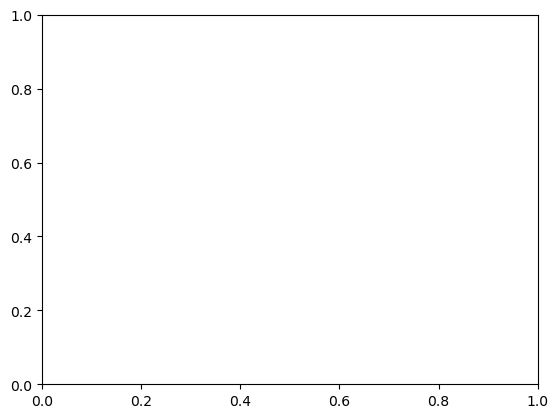

In [1]:
import koma.oma, koma.plot
import numpy as np
import matplotlib.pyplot as plt
import koma.clustering
import geneate_vibration_data
import strid
import copy

from scipy.signal import detrend, welch, resample

from knutils.modal import statespace as to_A
from knutils.structural import shearframe
from beef.newmark import newmark_lin
import plot_koma

In [2]:
path = "vibration_data/data_stochastic_3_floor_"

number_of_realizations = 100

### Data generation

In [29]:
for i in range(number_of_realizations):
    geneate_vibration_data.generate_data(9, path + str(i) + ".npz")

### Define SSI parameters

In [3]:
i = 50
s = 1

orders = np.arange(1, 50, 1)
stabcrit = {'freq': 0.2, 'damping': 0.2, 'mac': 0.5 }

### Cov-SSI call and pole clustering

In [4]:
freq_modes = []

for j in range(number_of_realizations):

    data = np.load(path + str(j) + ".npz")
    y = data["y"]
    #print(y.shape)
    fs = data["fs"]
    #print(fs)
    true_f = data["true_frequencies"].transpose()
    true_xi = data["true_damping"].transpose()
    true_modeshapes = data["true_modeshapes"].transpose()

    # Cov-SSI
    ssid = strid.CovarianceDrivenStochasticSID(y, fs) #, ix_references)
    modes = {}
    for order in orders:
        A, C, G, R0 = ssid.perform(order, i)
        modes[order] = strid.Mode.find_modes_from_ss(A, C, ssid.fs)

    # Sorting routine
    lambdas = []
    phis = []

    for order in modes.keys():
        modes_in_order = modes[order]
        lambdas_in_order = []
        phis_in_order = []
        for mode in modes_in_order:
            lambdas_in_order.append(mode.eigenvalue)
            phis_in_order.append(mode.eigenvector)
        lambdas.append(np.array(lambdas_in_order))
        phis.append(np.array(phis_in_order).transpose())

    lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambdas, phis, orders, s, stabcrit=stabcrit, valid_range={'freq': [0, np.inf], 'damping':[0, 0.2]}, indicator='freq', return_both_conjugates=False)

    #Pole clustering
    pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=25, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
    prob_threshold = 0.99   #probability of pole to belong to cluster, based on estimated "probability" density function
    args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

    xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

    xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
    fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

    xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
    fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

    freq_modes.append([freq for freq in fn_mean])



#freq_modes = np.array(freq_modes)

In [5]:
for i in range (len(freq_modes)):
    print(len(freq_modes[i]))

9
9
9
9
10
9
9
9
9
9
9
9
9
9
9
9
10
9
9
9
9
9
9
9
9
9
10
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
9
9
9
9
9
9
9
9
9


In [6]:
print(len(freq_modes))
print((freq_modes[1]))
new_freqs = np.empty(shape=[number_of_realizations, len(true_f)], dtype=object)
print(new_freqs.shape)


100
[0.08333426418694462, 0.2470031686303854, 0.4036780678826598, 0.5513696479816308, 0.6824198155617683, 0.7916848353047528, 0.8836609649238925, 0.9535866372366469, 0.9930748537621137]
(100, 9)


In [1]:
def remove_and_return_element(lst, condition):
    for i in range(len(lst)):
        if condition(lst[i]):
            return lst.pop(i)
    return None  # Return None if no element satisfies the condition

def remove_and_return_min_distance(lst, reference):
    min_element = min(lst, key=lambda x: abs(x - reference), default="EMPTY")
    if min_element in lst and abs(min_element-reference)<0.03:
        lst.remove(min_element)
        return min_element
    else:
        return None

In [2]:
#preallocating vector for sorted frequencies
new_freqs = np.array(np.empty(shape=[number_of_realizations, len(true_f)], dtype=object), dtype=np.float)
candidates = copy.deepcopy(freq_modes)

for i in range(number_of_realizations):
    for j in range(len(true_f)):
        candidate = remove_and_return_min_distance(candidates[i], true_f[j])
        new_freqs[i, j] = candidate


#remove_and_return_element(candidates[i], lambda x: np.abs(true_f[j]-x)/np.max([x, true_f[j]]) < 0.035 )

NameError: name 'np' is not defined

In [9]:
freqs = []
num = []

for i in range(number_of_realizations):
    freqs.extend(freq_modes[i])
    num.extend(np.ones_like(freq_modes[i])*i)

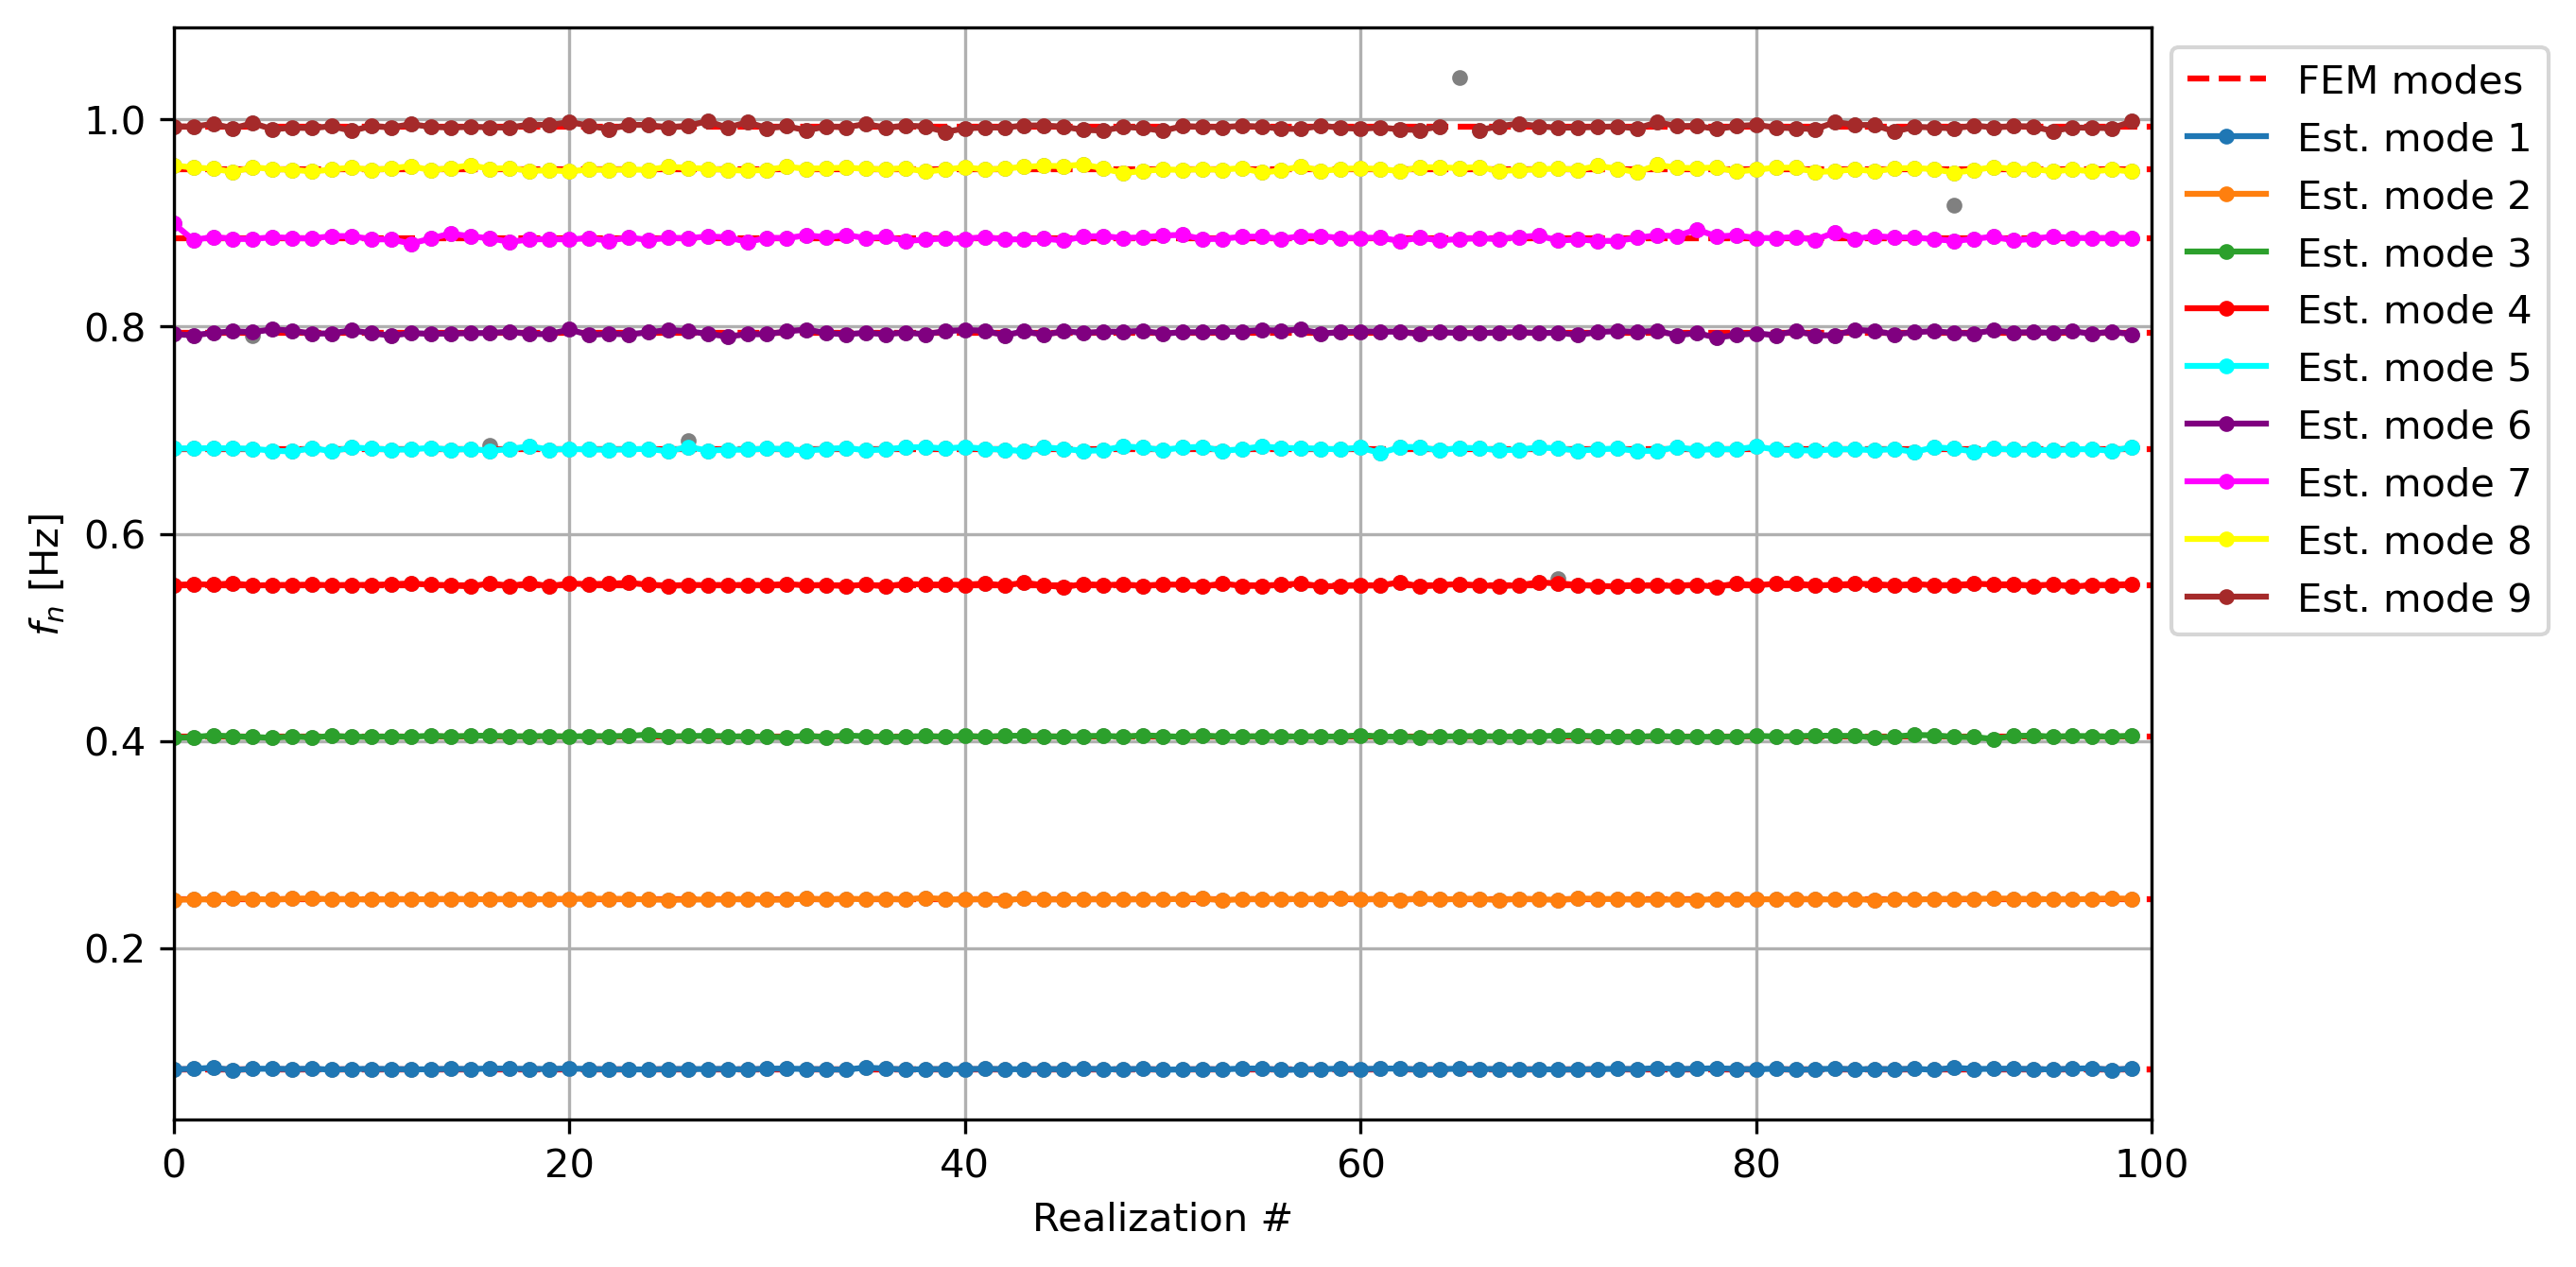

In [19]:
#Plot

colors =['tab:blue', 'tab:orange', 'tab:green', 'red', 'cyan', 'purple', 'magenta', 'yellow', 'brown']

plt.figure(figsize=(9, 5), dpi=300)
plt.axhline(y = true_f[0], color = 'r', linestyle = '--', label="FEM modes")
plt.scatter(np.array(num), np.array(freqs), marker='.', color='grey')

for i in range(len(true_f)):
    if (i<len(true_f)):
        plt.axhline(y = true_f[i], color = 'r', linestyle = '--')
    plt.plot(np.arange(0, number_of_realizations), new_freqs[:,i], color=colors[i], linestyle="-", marker=".", label="Est. mode " + str(i+1))

plt.grid()
plt.legend(bbox_to_anchor = (1,1))
plt.xlabel("Realization #")
plt.ylabel("$f_n$ [Hz]")
#plt.ylim([0,1.05])
plt.xlim([0,100])
plt.savefig("num_example.jpg", bbox_inches='tight')
plt.show()

In [20]:
print(np.count_nonzero(~np.isnan(new_freqs), axis=0))

[100 100 100 100 100 100 100 100  99]


In [21]:
print(np.count_nonzero(~np.isnan(new_freqs)))
print(len(freqs))

899
905


In [22]:
f_mean = np.nanmean(new_freqs, axis=0)
print(f_mean)

[0.08316506 0.24717248 0.40436786 0.55066663 0.68178021 0.79415622
 0.88571816 0.95217596 0.99286872]


In [23]:
print((true_f))

[0.08312307 0.24710182 0.40434028 0.5505494  0.68174096 0.7943364
 0.88526442 0.95204473 0.99285575]


In [24]:
print(100*np.abs(true_f-f_mean)/true_f)

[0.05051479 0.02859544 0.00681894 0.02129366 0.00575721 0.02268287
 0.05125532 0.01378413 0.00130728]
